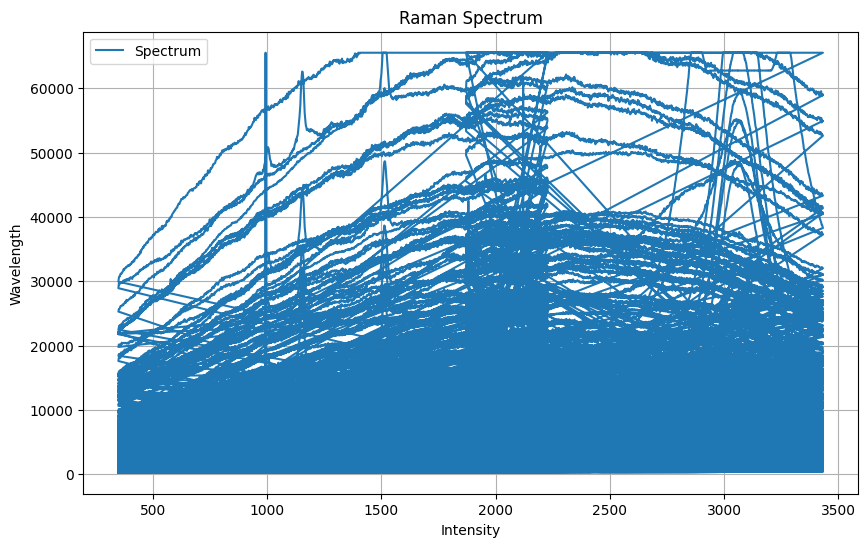

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to process files in a directory
def process_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
    return file_paths

#1) FIND FILES
# Define directory
directory = '/kaggle/input/microsc-raw-txt'
file_paths = process_files(directory)

# Output directory
output_directory = '/kaggle/working/cleaned_files'
os.makedirs(output_directory, exist_ok=True)  # create output directory if it does not exist

# 2) CLEAN DATA
for file_path in file_paths:
    # Read file
    data = pd.read_csv(file_path, delimiter="\t", header=None)

    # Check if there are at least two columns
    if data.shape[1] >= 2:
        # Extract the first two columns
        cleaned_data = data.iloc[:, :2]

        # Add column names
        cleaned_data.columns = ['Wavelength', 'Intensity']

        # Save the cleaned data
        file_name = os.path.basename(file_path)
        cleaned_file_path = os.path.join(output_directory, file_name.replace('.txt', '.csv'))  # change extension to .csv
        cleaned_data.to_csv(cleaned_file_path, sep="\t", index=False)
        
        
# 3) CONCATENATE FILES
dfs = []

for filename in os.listdir(output_directory):
    if filename.endswith(".csv"):  # update condition based on file extension
        file_path = os.path.join(output_directory, filename)
        df = pd.read_csv(file_path, delimiter="\t")  # specify delimiter
        dfs.append(df)

if dfs:  # check if dfs list is not empty
    concatenated_df = pd.concat(dfs, ignore_index=True)

# Save concatenated data as CSV
concatenated_file_path = '/kaggle/working/concatenated_data.csv'
concatenated_df.to_csv(concatenated_file_path, index=False)
    
# 4) PLOT SPECTRA
def plot_spectra(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Wavelength'], df['Intensity'], label='Spectrum')
    plt.xlabel('Intensity')
    plt.ylabel('Wavelength')
    plt.title('Raman Spectrum')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot spectra
plot_spectra(concatenated_df)

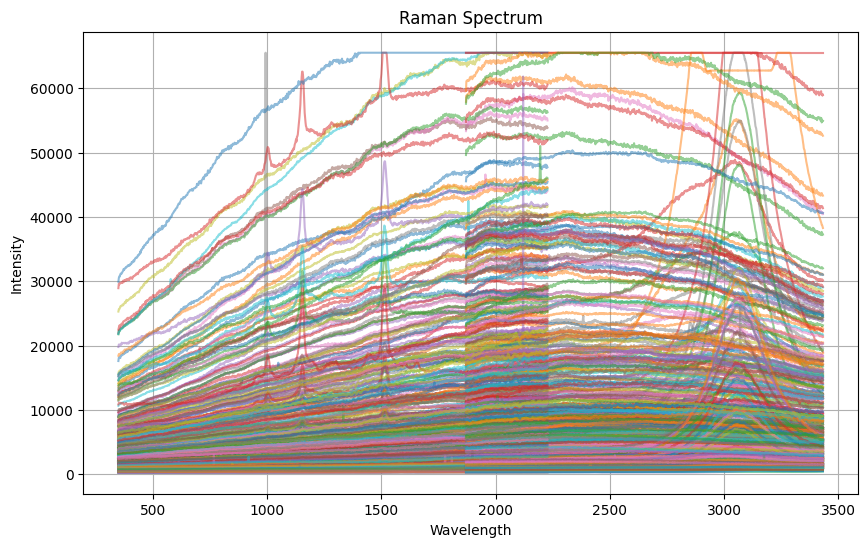

In [2]:
# new try (30 aug)
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to process files in a directory
def process_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
    return file_paths

# 1) FIND FILES
# Define directory
directory = '/kaggle/input/microsc-raw-txt'
file_paths = process_files(directory)

# Output directory
output_directory = '/kaggle/working/cleaned_files'
os.makedirs(output_directory, exist_ok=True)  # create output directory if it does not exist

# 2) CLEAN DATA
for file_path in file_paths:
    # Read file
    data = pd.read_csv(file_path, delimiter="\t", header=None)

    # Check if there are at least two columns
    if data.shape[1] >= 2:
        # Extract the first two columns
        cleaned_data = data.iloc[:, :2]

        # Add column names
        cleaned_data.columns = ['Wavelength', 'Intensity']
        
        # Add a column with Spectrum ID 
        cleaned_data['Spectrum_ID'] = os.path.basename(file_path).replace('.txt', '')

        # Save cleaned data
        file_name = os.path.basename(file_path)
        cleaned_file_path = os.path.join(output_directory, file_name.replace('.txt', '.csv'))  # change extension to .csv
        cleaned_data.to_csv(cleaned_file_path, sep="\t", index=False)
        
# 3) CONCATENATE FILES
dfs = []

for filename in os.listdir(output_directory):
    if filename.endswith(".csv"):  # update condition based on file extension
        file_path = os.path.join(output_directory, filename)
        df = pd.read_csv(file_path, delimiter="\t")  # specify delimiter
        dfs.append(df)

if dfs:  # check if dfs list is not empty
    concatenated_df = pd.concat(dfs, ignore_index=True)

# Save concatenated data as CSV
concatenated_file_path = '/kaggle/working/concatenated_data.csv'
concatenated_df.to_csv(concatenated_file_path, index=False)
    
# 4) PLOT SPECTRA
def plot_spectra(df):
    plt.figure(figsize=(10, 6))
    
    # Group data by Spectrum_ID and plot each group individually
    for spectrum_id, group in df.groupby('Spectrum_ID'):
        plt.plot(group['Wavelength'], group['Intensity'], label=spectrum_id, alpha=0.5)
    
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.title('Raman Spectrum')
    plt.grid(True)
    plt.show()

# Plot spectra
plot_spectra(concatenated_df)


  Spectrum_ID  Wavelength  Intensity
0  Spectrum_1   1870.4686   0.000000
1  Spectrum_1   1872.1963   0.000000
2  Spectrum_1   1873.9233   0.000000
3  Spectrum_1   1875.6483   0.000000
4  Spectrum_1   1877.3750  35.837901


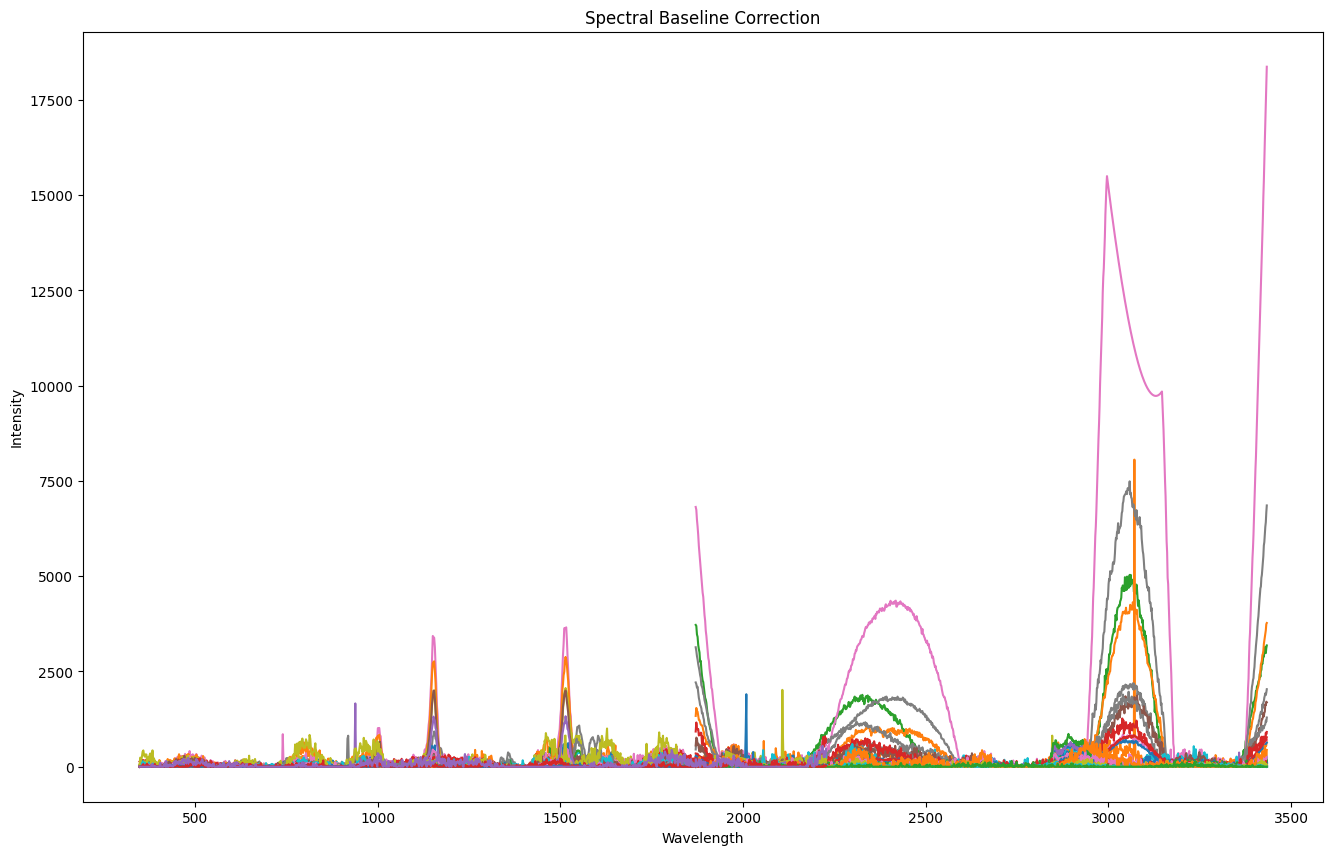

In [3]:
# 2) BASELINE CORRECTION (WHITTAKER SMOOTHER APPROACH)
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define baseline correction function
def raman_baseline_correction(wavenumbers, spectrum, polynomial_order):
    def chebyshev_polynomial(x, *coefficients):
        return np.polynomial.chebyshev.chebval(x, coefficients)

    # Fit Chebyshev polynomial to entire spectrum
    baseline_coefficients, _ = curve_fit(chebyshev_polynomial, wavenumbers, spectrum, p0=np.zeros(polynomial_order + 1))

    # Subtract fitted polynomial from original spectrum
    corrected_baseline = spectrum - chebyshev_polynomial(wavenumbers, *baseline_coefficients)

    return baseline_coefficients, corrected_baseline 

# Load data
df = pd.read_csv('/kaggle/working/concatenated_data.csv')

# Initialize an empty list to store DataFrames
dfs = []

# Initialize a counter for generating unique IDs
id_counter = 1

# Perform baseline correction & append to list
for Spectrum_ID in df['Spectrum_ID'].unique():
    # Extract relevant data for current spectrum
    wavenumbers_spectrum = df[df['Spectrum_ID'] == Spectrum_ID]['Wavelength']
    intensity_spectrum = df[df['Spectrum_ID'] == Spectrum_ID]['Intensity']
    
    # Check if data is not empty
    if wavenumbers_spectrum.empty or intensity_spectrum.empty:
        print(f"No data found for spectrum ID: {Spectrum_ID}")
        continue

    # Perform baseline correction for current spectrum
    polynomial_order_spectrum = 5
    baseline_coefficients_spectrum, corrected_baseline_spectrum = raman_baseline_correction(wavenumbers_spectrum, intensity_spectrum, polynomial_order_spectrum)

    # Ensure corrected intensity is non-negative
    corrected_baseline_spectrum = np.maximum(corrected_baseline_spectrum, 0)
    
    # Generate a unique ID for each spectrum
    spectrum_id = f'Spectrum_{id_counter}'
    id_counter += 1

    # Add Spectrum_ID column back to corrected DataFrame
    corrected_baseline_df = pd.DataFrame({'Spectrum_ID': spectrum_id, 'Wavelength': wavenumbers_spectrum, 'Intensity': corrected_baseline_spectrum})
    
    # Reorganize columns
    corrected_baseline_df = corrected_baseline_df[['Spectrum_ID', 'Wavelength', 'Intensity']]

    # Append corrected spectrum DataFrame to the list
    dfs.append(corrected_baseline_df)

# Concatenate all DataFrames into a single
combined_df = pd.concat(dfs, ignore_index=True)

# Save combined DataFrame in one file
combined_df.to_csv("combined_file.csv", index=False)

# Print first few rows
print(combined_df.head())

# Plot
plt.figure(figsize=(16, 10), dpi=100)

num_spectra_to_plot = 135 
for spectrum_id in combined_df['Spectrum_ID'].unique()[:num_spectra_to_plot]:
    # Extract data for current spectrum
    spectrum_data = combined_df[combined_df['Spectrum_ID'] == spectrum_id]
    wavenumbers = spectrum_data['Wavelength']
    corrected_intensity = spectrum_data['Intensity']
    plt.plot(wavenumbers, corrected_intensity, label=f'Spectrum {spectrum_id}')

plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Spectral Baseline Correction')
plt.show()

Smoothed spectra saved to /kaggle/working/combined_microscope.csv
Index(['Spectrum_ID', 'Wavelength', 'Intensity'], dtype='object')


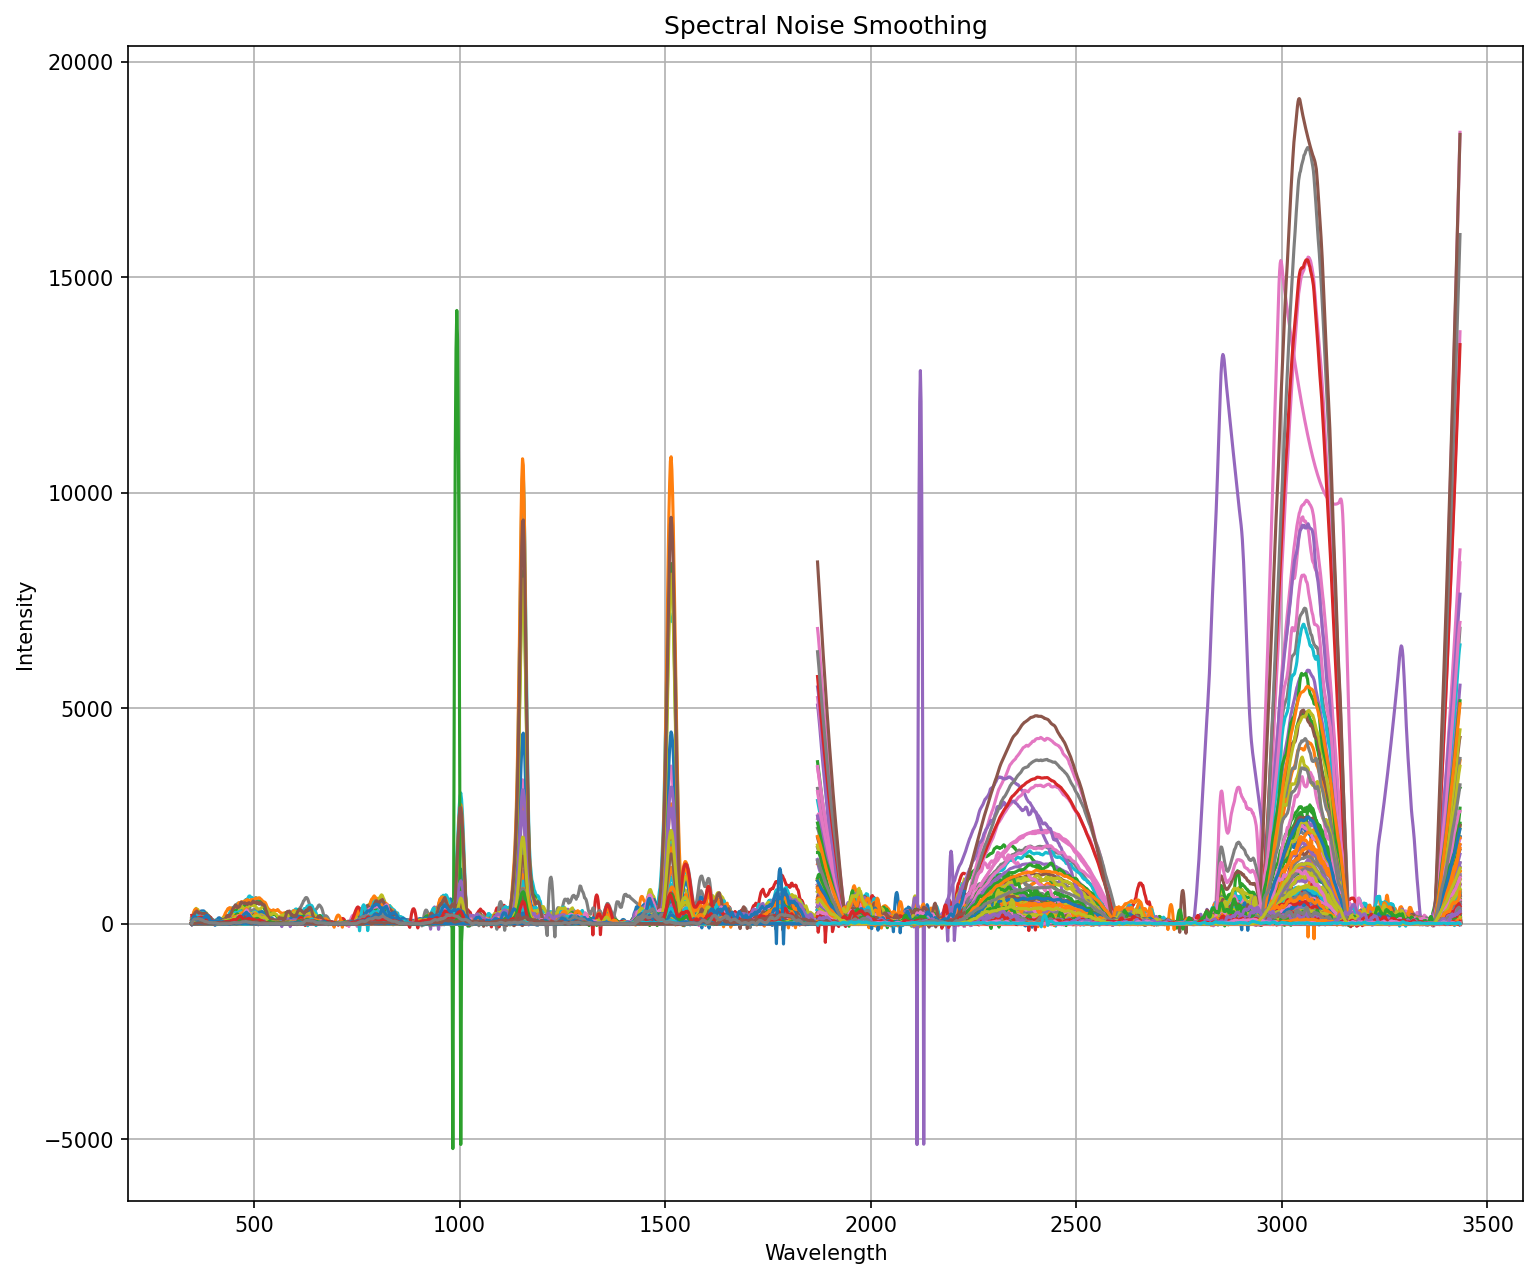

In [4]:
# 4) SMOOTHING NOISE BY SAVITZKY-GOLAY FILTER 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Function to apply Savitzky-Golay filter to intensity data
def savgol_filter_intensity(intensity_data, window_size, poly_order):
    intensity = savgol_filter(intensity_data, window_size, poly_order)
    return intensity

# Read data
cleaned_spectrum_file = 'combined_file.csv'
cleaned_data = pd.read_csv(cleaned_spectrum_file)

# Define parameters for Savitzky-Golay filter
window_size = 11  # window size must be odd
poly_order = 3

# Smooth intensity data for each spectrum
smoothed_spectra = []

# Iterate over unique spectrum IDs
for spectrum_id in cleaned_data['Spectrum_ID'].unique():
    spectrum_data = cleaned_data[cleaned_data['Spectrum_ID'] == spectrum_id].copy()

    # Check if spectrum exists in data
    if not spectrum_data.empty:
        # Convert 'Corrected_Intensity' column to numeric
        spectrum_data['Intensity'] = pd.to_numeric(spectrum_data['Intensity'], errors='coerce')

        # Drop rows with NaN values (if any)
        spectrum_data = spectrum_data.dropna()
        
        # Check if window size is smaller than or equal to data size
        if window_size <= len(spectrum_data):
            # Apply Savitzky-Golay filter to smooth intensity data
            smoothed_intensity = savgol_filter_intensity(spectrum_data['Intensity'], window_size, poly_order)

            # Create a DataFrame with smoothed intensity data along with spectrum ID & wavelengths
            smoothed_spectrum = pd.DataFrame({
                'Spectrum_ID': spectrum_id,
                'Wavelength': spectrum_data['Wavelength'],
                'Intensity': smoothed_intensity
            })

            # Append smoothed spectrum to the list
            smoothed_spectra.append(smoothed_spectrum)
            
# Concatenate into a single DataFrame
if smoothed_spectra:
    smoothed_data = pd.concat(smoothed_spectra, ignore_index=True)

    # Save to a CSV file
    smoothed_data_file = '/kaggle/working/combined_microscope.csv'
    smoothed_data.to_csv(smoothed_data_file, index=False)
    
    # Confirming successful saving
    print(f"Smoothed spectra saved to {smoothed_data_file}")
    print(smoothed_data.columns)
else:
    print("No spectra were successfully smoothed.")

# Plot
plt.figure(figsize=(12, 10), dpi=150)

for spectrum_id in smoothed_data['Spectrum_ID'].unique():
    spectrum_data = smoothed_data[smoothed_data['Spectrum_ID'] == spectrum_id]
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], label=spectrum_id)

plt.title ('Spectral Noise Smoothing')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()

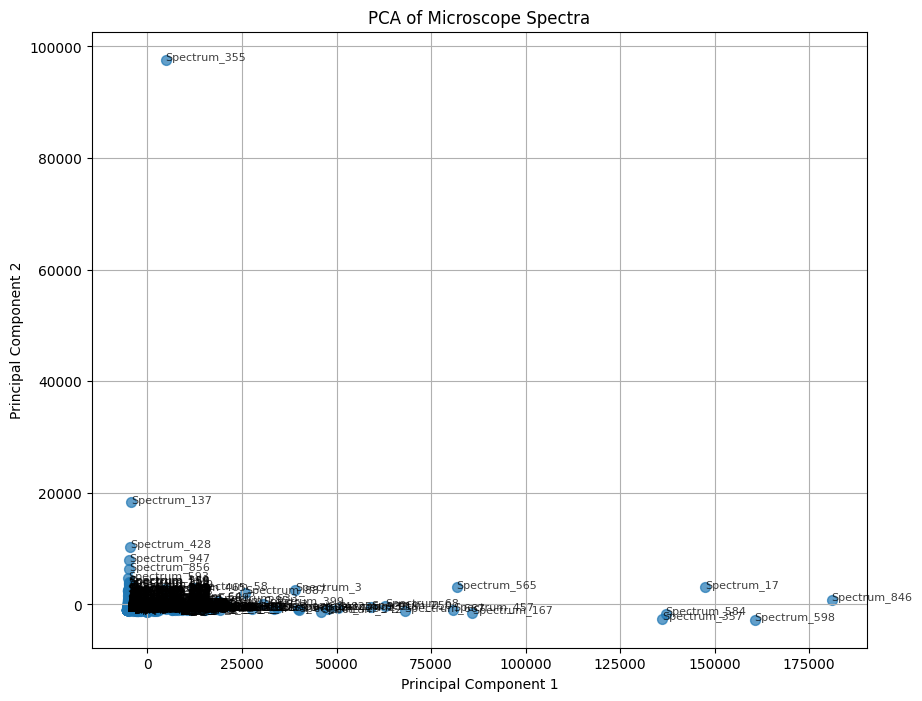

Explained variance by PC1: 0.87
Explained variance by PC2: 0.05


In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Load data
data = pd.read_csv('/kaggle/working/combined_microscope.csv')

# Aggregate duplicate entries by taking the mean of 'Intensity'
data_aggregated = data.groupby(['Spectrum_ID', 'Wavelength'], as_index=False).mean()

# Pivot the data to have each spectrum as a row
data_pivot = data_aggregated.pivot(index='Spectrum_ID', columns='Wavelength', values='Intensity')

# Drop the index name for cleaner plotting
data_pivot.columns.name = None

# Prepare the data for PCA
X = data_pivot.values

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_imputed)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], s=50, alpha=0.7)
for i, spectrum_id in enumerate(data_pivot.index):
    plt.annotate(spectrum_id, (pca_df['PC1'][i], pca_df['PC2'][i]), fontsize=8, alpha=0.75)

plt.title('PCA of Microscope Spectra')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Print explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by PC1: {explained_variance[0]:.2f}')
print(f'Explained variance by PC2: {explained_variance[1]:.2f}')
